<a href="https://colab.research.google.com/github/nilanka76/ML-Models/blob/main/helmet_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/drive/MyDrive/Helmet/Train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Class names from subdirectorys
print(class_names)

['With_helmet' 'Without_helmet']


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")
  
  return img

['BikesHelmets66.png']
Image shape: (300, 400, 4)


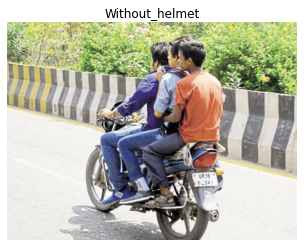

In [6]:
img = view_random_image(target_dir="/content/drive/MyDrive/Helmet/Train/",
                        target_class="Without_helmet")

>**Support Functions**

In [7]:
def plot_loss_curve(History): 
  train_loss= History.history["loss"]
  train_accuracy= History.history["accuracy"]

  val_loss= History.history["val_loss"]
  val_accuracy= History.history["val_accuracy"]

  epochs = range(len(History.history["loss"]))

  plt.figure(figsize=(7,7))
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.legend()

  plt.figure(figsize=(7,7))
  plt.plot(epochs, train_accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.legend()

>**Model**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4
EPOCHS = 5
BS = 32

DIRECTORY = r"/content/drive/MyDrive/Helmet/Train"
CATEGORIES = ["With_helmet", "Without_helmet"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading images...


In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

TL_model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
TL_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
TL_model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = TL_model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS, #EPOCHS = 5
	epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] training head...
Epoch 1/5
19/19 [==============================] - 21s 524ms/step - loss: 0.7689 - accuracy: 0.5724 - val_loss: 0.6332 - val_accuracy: 0.6993
Epoch 2/5
19/19 [==============================] - 8s 404ms/step - loss: 0.6732 - accuracy: 0.6760 - val_loss: 0.5956 - val_accuracy: 0.6993
Epoch 3/5
19/19 [==============================] - 8s 402ms/step - loss: 0.6221 - accuracy: 0.6776 - val_loss: 0.5770 - val_accuracy: 0.7059
Epoch 4/5
19/19 [==============================] - 8s 404ms/step - loss: 0.5879 - accuracy: 0.7072 - val_loss: 0.5639 - val_accuracy: 0.7059
Epoch 5/5
19/19 [==============================] - 8s 406ms/step - loss: 0.5906 - accuracy: 0.7023 - val_loss: 0.5454 - val_accuracy: 0.7190


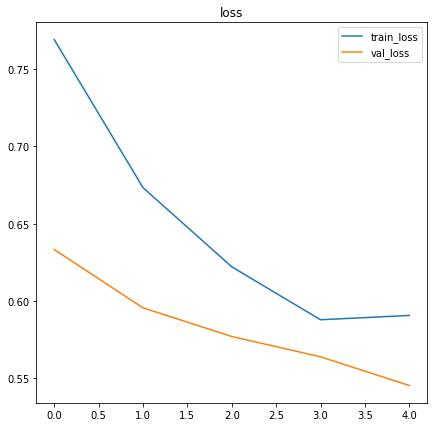

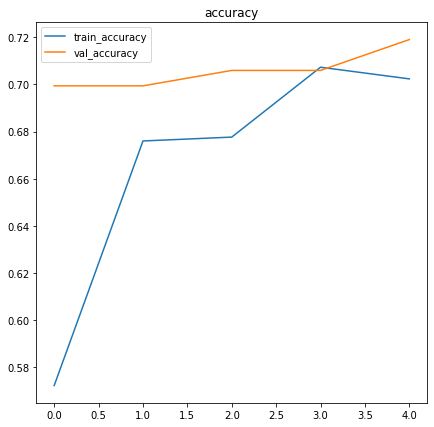

In [15]:
plot_loss_curve(H)

In [17]:
TL_model.evaluate(testX, testY)

5/5 [==============================] - 1s 227ms/step - loss: 0.5454 - accuracy: 0.7190


[0.545370876789093, 0.7189542651176453]

In [18]:
TL_model.save("Helmet_detector.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
